# Import Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
dataframe = pd.read_csv("DataSet.csv", delimiter='|')
dataframe

,CustomerID,num_transactions,total_order_value,days_between_trans,repeat_share,dog_share
0,dwa726,12.0,329.88,33.77,0.459760,0.255687
1,asy963,1.0,11.28,234.14,0.090312,0.549722
2,zgt592,14.0,322.84,33.22,0.324031,0.244276
3,spt267,17.0,402.90,30.86,0.353778,0.375446
4,oog686,5.0,64.60,75.20,0.188762,0.172051
...,...,...,...,...,...,...
99998,aai561,4.0,52.60,85.95,0.212368,0.137752
99999,fls458,12.0,308.28,33.96,0.402527,0.162402
100000,meq929,14.0,360.92,32.46,0.530069,0.220001
100001,zbc489,13.0,338.13,34.98,0.417244,0.330881


## 1.  EDA on  DataFrame to get more insight 

### 1.1 Check for missing values

In [3]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   CustomerID          100003 non-null  object 
 1   num_transactions    99925 non-null   float64
 2   total_order_value   99905 non-null   float64
 3   days_between_trans  99918 non-null   float64
 4   repeat_share        99912 non-null   float64
 5   dog_share           99896 non-null   float64
dtypes: float64(5), object(1)
memory usage: 4.6+ MB


In [4]:
dataframe.isnull().sum()

CustomerID              0
num_transactions       78
total_order_value      98
days_between_trans     85
repeat_share           91
dog_share             107
dtype: int64

<Axes: >

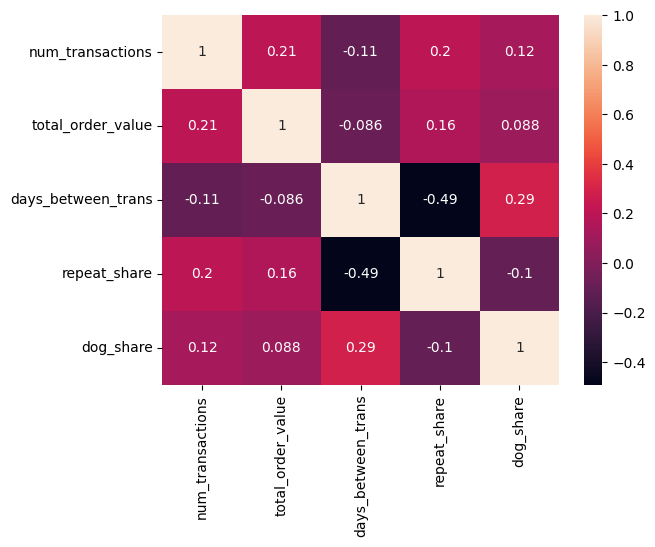

In [5]:
import seaborn as sns

# Show a heatmap of correlations
sns.heatmap(dataframe.drop(columns=['CustomerID']).corr(), annot=True)

In [6]:
dataframe = dataframe.dropna()

### Summarizing `missing values` observations
- all variables expect _CustomerID_ contain missing values
- **for simiplicity rows with missing values were removed (459 rows out of 100,003 removed, still large volume of data remaining)**
- other possibilities how to deal with missing values:
    - Replace missing values with the mean or median
    - ask client whether they can provide supplementary data
    - domain-knowledge: e.g. estimate total_order_value by multiplying num_transactions by the average transaction value
    - linear regression could be used to estimate missing values (in this case study it is not recommended due to the relatively weak correlations observed between variables. An exception could be made for days_between_trans and repeat_share, which show a moderate negative correlation.)

### 1.2 Outlier Treatment

In [7]:
dataframe.describe()

,num_transactions,total_order_value,days_between_trans,repeat_share,dog_share
count,99544.000000,99544.000000,99544.000000,99544.000000,99544.000000
mean,17.707667,452.945087,75.526286,0.314556,0.267196
std,90.606600,3020.050715,75.798578,0.176373,0.240252
min,-19.000000,-10236.000000,-234.210000,-0.816563,-0.913288
25%,4.000000,54.640000,32.480000,0.206213,0.153121
50%,12.000000,273.665000,37.340000,0.334596,0.230384
75%,15.000000,365.920000,85.790000,0.404329,0.324050
max,4003.000000,129134.400000,2349.290000,8.284485,9.962103


**Observations:**
- **Negative Values:** Negative values in the dataset are asumed to be errors, as they are not feasible in a retail context where transaction counts, order values, and days between transactions should logically be positive --> remove rows with negative values
- **High Standard Deviation:** A significant standard deviation in num_transactions, total_order_value, and days_between_trans indicates a wide range of values, suggesting the existence of outliers --> investigate wether outlier represents an error or extreme purchasing behavior

### 1.2.1 Negative Values

**Remove rows with negative values**

In [8]:
numeric_cols = ['num_transactions', 'total_order_value', 'days_between_trans', 'repeat_share', 'dog_share']

# Remove rows where any of the selected numeric columns has a negative value
dataframe = dataframe[(dataframe[numeric_cols] >= 0).all(axis=1)]

In [9]:
dataframe.describe()

,num_transactions,total_order_value,days_between_trans,repeat_share,dog_share
count,99089.000000,99089.000000,99089.000000,99089.000000,99089.000000
mean,17.739083,454.022257,75.670204,0.315213,0.267762
std,90.760018,3025.851120,75.649981,0.175536,0.239850
min,1.000000,7.230000,1.170000,0.018255,0.000000
25%,4.000000,54.850000,32.490000,0.206455,0.153424
50%,12.000000,274.080000,37.380000,0.334853,0.230498
75%,15.000000,365.960000,85.800000,0.404409,0.324201
max,4003.000000,129134.400000,2349.290000,8.284485,9.962103


### 1.2.2 Outlier Values

In [10]:
# Function to identify outliers using the IQR method
def identify_outliers(df):
    outliers_dict = {}
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outliers_dict[column] = outliers
        
        # Print summary
        print(f"{column}: {len(outliers)} outliers identified.")
        
    return outliers_dict

# Identifying outliers
outliers_dict = identify_outliers(dataframe)

num_transactions: 1580 outliers identified.
total_order_value: 1590 outliers identified.
days_between_trans: 13711 outliers identified.
repeat_share: 1096 outliers identified.
dog_share: 7101 outliers identified.


In [11]:
# Optional: Inspect outliers for a specific column
outliers_dict['num_transactions']

,CustomerID,num_transactions,total_order_value,days_between_trans,repeat_share,dog_share
22,doa613,401.0,9728.26,1.77,0.922199,0.815214
41,lbx354,398.0,10531.08,2.24,1.000000,1.000000
107,nrh195,399.0,11207.91,1.98,0.872487,0.747527
195,tct456,399.0,9009.42,2.06,0.801998,0.586585
212,ahx695,400.0,10816.00,1.45,1.000000,0.774635
...,...,...,...,...,...,...
99877,zof179,399.0,9759.54,1.91,1.000000,0.918986
99894,jkt439,400.0,9656.00,2.16,0.590835,1.000000
99911,qkc114,400.0,18786.83,2.00,1.000000,0.720342
99916,xsu566,397.0,10838.10,2.25,0.838943,0.553102


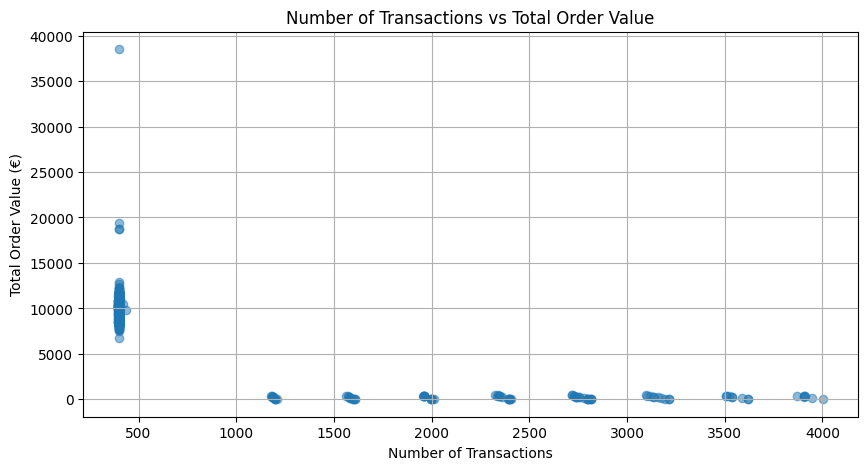

In [12]:
import matplotlib.pyplot as plt

#Plotting num_transactions against total_order_value
plt.figure(figsize=(10, 5))
plt.scatter((outliers_dict['num_transactions'])['num_transactions'], (outliers_dict['num_transactions'])['total_order_value'], alpha=0.5)
plt.title('Number of Transactions vs Total Order Value')
plt.xlabel('Number of Transactions')
plt.ylabel('Total Order Value (€)')
plt.grid(True)
plt.show()

In [13]:
dataframe = dataframe[~(dataframe['num_transactions'] > dataframe['total_order_value'])]

### Summarizing `Outlier` observations
- Rows with negative values have been excluded from the dataset. These are considered anomalies likely resulting from data entry errors
- Identified outliers where _num_transactions_ exceeded _total_order_value_. Given the business context, these instances were deemed erroneous and subsequently removed, as transaction counts would logically correlate with a higher total order value.
- Outliers representing extreme purchasing behavior have been retained. These are not necessarily indicative of data quality issues but may reflect a segment of high-value or niche customers, which could provide valuable insights for targeted marketing strategies and business development.

### 1.3 Analysis Context: Verifying Customer Uniqueness

In [14]:
customer_frequencies = dataframe['CustomerID'].value_counts()
customer_frequencies

CustomerID
pht525    4
wbc946    4
eeq719    4
ioj540    2
gif468    2
         ..
yvl698    1
bcz446    1
hbc809    1
fea552    1
huo987    1
Name: count, Length: 98744, dtype: int64

In [15]:
specified_customer_id = 'pht525'

# Filter the dataframe for the specified CustomerID
specified_customer_df = dataframe[dataframe['CustomerID'] == specified_customer_id]
specified_customer_df

,CustomerID,num_transactions,total_order_value,days_between_trans,repeat_share,dog_share
25068,pht525,3.0,39.36,98.65,0.195831,0.245896
99757,pht525,3.0,39.36,98.65,0.195831,0.245896
99781,pht525,3.0,39.36,98.65,0.195831,0.245896
99782,pht525,3.0,39.36,98.65,0.195831,0.245896


In [16]:
dataframe = dataframe.drop_duplicates()

In [17]:
customer_frequencies = dataframe['CustomerID'].value_counts()
customer_frequencies

CustomerID
dwa726    1
uyu117    1
zzz987    1
mio916    1
vdm915    1
         ..
bxs296    1
vpw910    1
dij497    1
uuf386    1
huo987    1
Name: count, Length: 98744, dtype: int64

### Summarizing `Customer Uniqueness` observations
- The dataset included duplicate entries for certain customers.
- These duplicates were identified and removed.
- Post-removal, each unique customer is represented just once in the dataset.

### 1.4 Data transformation & standardization

- Transformations like the logarithm reduce skewness in variables, leading to distributions that are more normal, which many statistical methods and machine learning algorithms assume or perform better with.

- Standardization rescales variables to a standard range or distribution, which is crucial when combining features that have different units or scales, allowing for fair comparison and weighting in algorithms.

array([[<Axes: title={'center': 'num_transactions'}>,
        <Axes: title={'center': 'total_order_value'}>],
       [<Axes: title={'center': 'days_between_trans'}>,
        <Axes: title={'center': 'repeat_share'}>],
       [<Axes: title={'center': 'dog_share'}>, <Axes: >]], dtype=object)

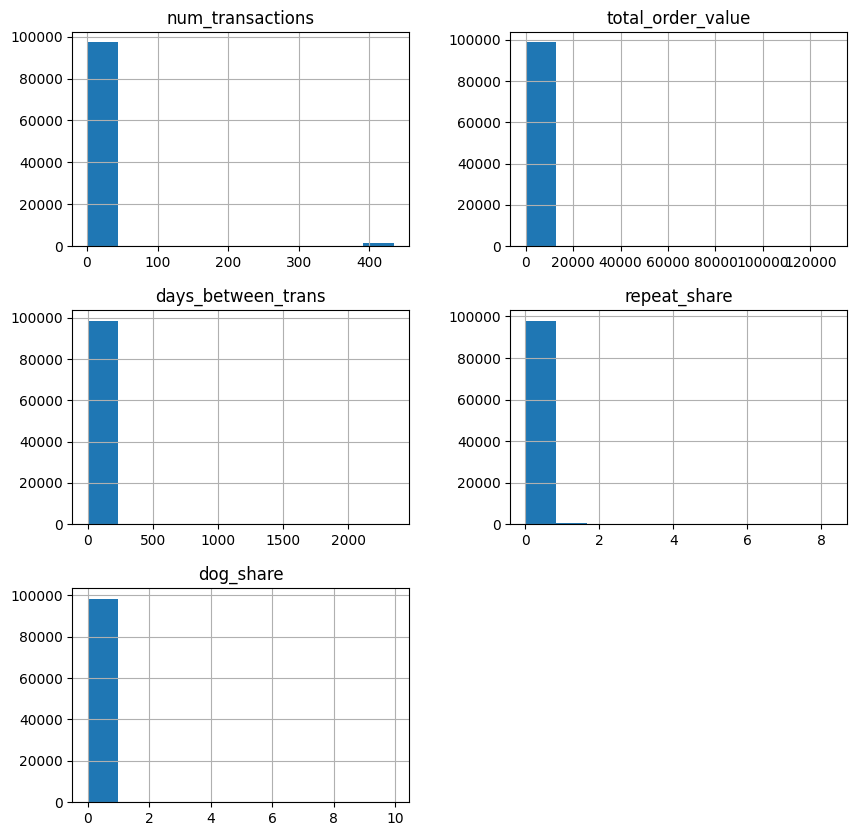

In [18]:
# create histograms of numeric variables
dataframe.hist(figsize = (10,10))

In [19]:
(dataframe.drop(columns=['CustomerID'])).skew()

num_transactions       7.791774
total_order_value     28.772922
days_between_trans     5.257267
repeat_share          13.487551
dog_share             13.862921
dtype: float64

**Skewness:**
In statistics, skewness is a measure of the asymmetry of the probability distribution of a random variable about its mean. The skewness value can be positive or negative, or even undefined. If skewness = 0, the data are perfectly symmetrical. <br />
A skewness of exactly zero is quite unlikely for real-world data, so how can you interpret the skewness number?<br />
(Bulmer 1979) — a classic — suggests this <b>rule of thumb</b>:

- If skewness is <b>less than -1 or greater than 1</b>, the distribution is <b>highly</b> skewed.
- If skewness is <b>between -1 and -0.5 or between 0.5 and 1</b>, the distribution is </b>moderately</b> skewed.
- If skewness is <b>between -0.5 and 0.5</b>, the distribution is approximately <b>symmetric</b>.

### Summarizing `Data transformation & standardization` observations
- all numeric variables are highly skewed --> transformation
- variables have different scales --> standardization

## 2. Data Preparation 

### 2.1 Variable Selection

I will not use **CustomerID** during clustering because it is a unique identifier that does not provide any meaningful information about customer behavior or characteristics for segmentation purposes.

### 2.2 Data Transformation

- log transformation is suitable for highly skewed variables
- square rooot transformation for _dog_share_ since it contains zero values

In [20]:
zero_values = (dataframe == 0).sum()
zero_values

CustomerID               0
num_transactions         0
total_order_value        0
days_between_trans       0
repeat_share             0
dog_share             1666
dtype: int64

In [21]:
dataframe['Log_num_transactions'] = np.log(dataframe['num_transactions'])
dataframe['Log_total_order_value'] = np.log(dataframe['total_order_value'])
dataframe['Log_days_between_trans'] = np.log(dataframe['days_between_trans'])
dataframe['Log_repeat_share'] = np.log(dataframe['repeat_share'])
dataframe['SQRT_dog_share'] = np.sqrt(dataframe['dog_share'])

In [22]:
(dataframe.drop(columns=['CustomerID'])).skew()

num_transactions           7.791774
total_order_value         28.772922
days_between_trans         5.257267
repeat_share              13.487551
dog_share                 13.862921
Log_num_transactions      -0.087035
Log_total_order_value     -0.258066
Log_days_between_trans    -0.275861
Log_repeat_share          -0.753279
SQRT_dog_share             1.195026
dtype: float64

array([[<Axes: title={'center': 'num_transactions'}>,
        <Axes: title={'center': 'total_order_value'}>,
        <Axes: title={'center': 'days_between_trans'}>],
       [<Axes: title={'center': 'repeat_share'}>,
        <Axes: title={'center': 'dog_share'}>,
        <Axes: title={'center': 'Log_num_transactions'}>],
       [<Axes: title={'center': 'Log_total_order_value'}>,
        <Axes: title={'center': 'Log_days_between_trans'}>,
        <Axes: title={'center': 'Log_repeat_share'}>],
       [<Axes: title={'center': 'SQRT_dog_share'}>, <Axes: >, <Axes: >]],
      dtype=object)

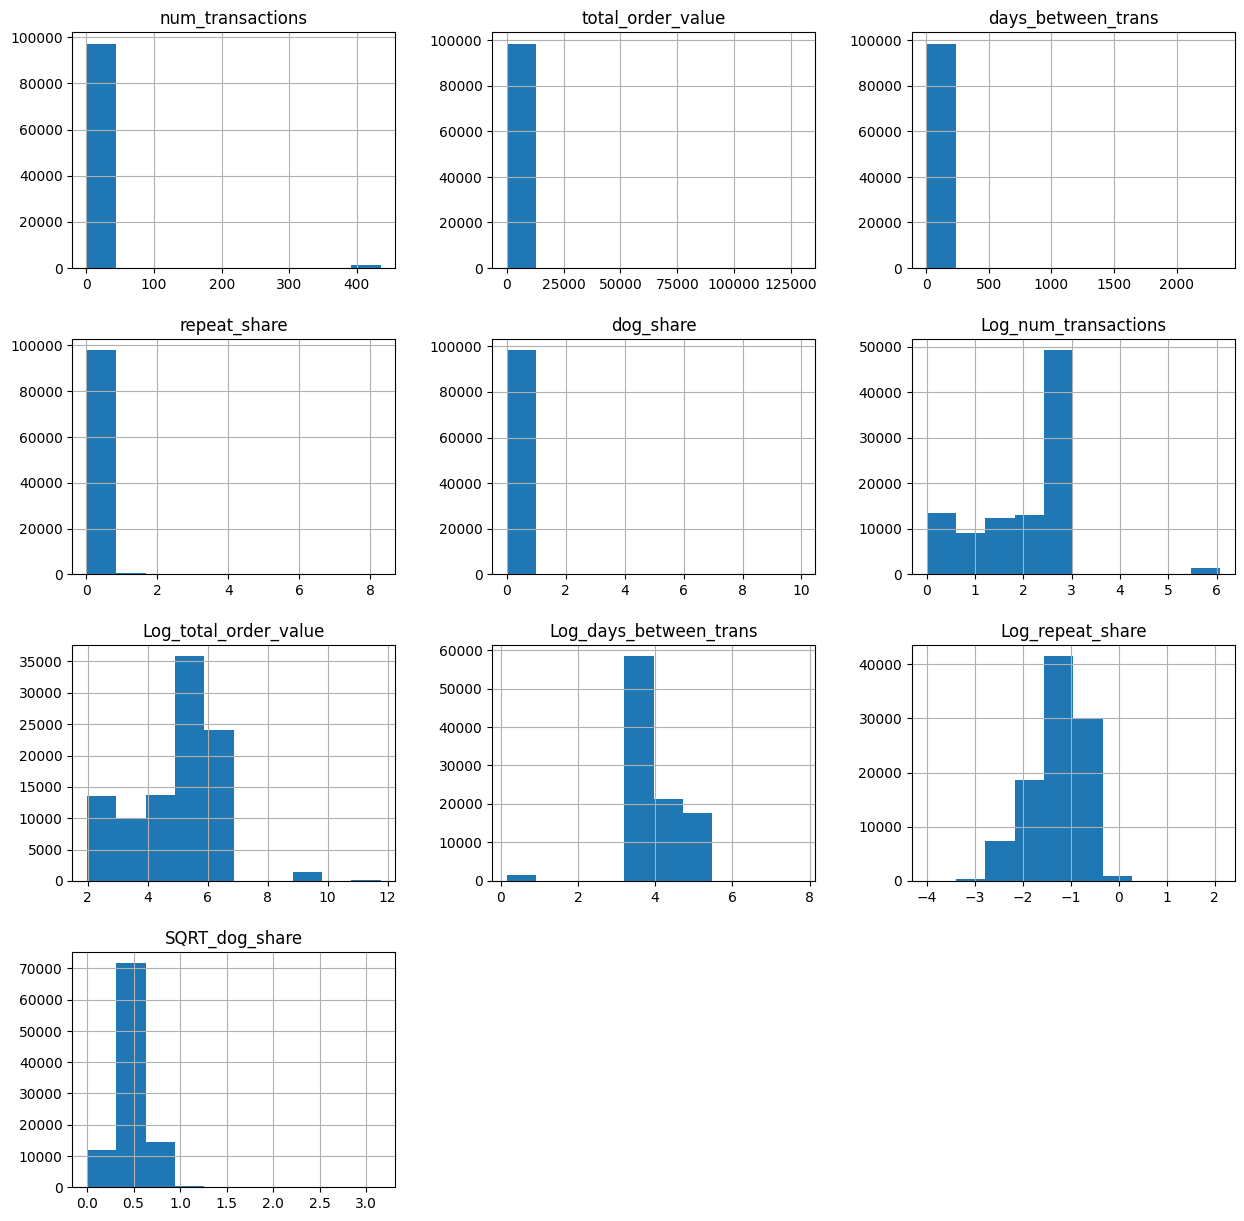

In [23]:
dataframe.hist(figsize = (15,15))

In [24]:
# Create a new dataset, which does not include the old variables that were transformed
df_trans = dataframe.drop(['CustomerID', 'num_transactions', 'total_order_value', 'days_between_trans', 'repeat_share', 'dog_share'], axis = 1)
df_trans.head()

,Log_num_transactions,Log_total_order_value,Log_days_between_trans,Log_repeat_share,SQRT_dog_share
0,2.484907,5.798729,3.519573,-0.777052,0.505655
1,0.000000,2.423031,5.455919,-2.404484,0.741432
2,2.639057,5.777157,3.503152,-1.126915,0.494242
3,2.833213,5.998688,3.429461,-1.039085,0.612736
4,1.609438,4.168214,4.320151,-1.667266,0.414791


### Summarizing `Data transformation` observations
- The skewness values before and after applying log transformation (and square root transformation for `dog_share`) show a significant reduction in skewness for most variables, indicating that these transformations helped in normalizing the distributions
- The log transformations of `num_transactions`, `total_order_value`, `days_between_trans`, and `repeat_share` significantly improved their skewness, bringing them closer to a normal distribution
- However, `SQRT_dog_share` still shows some skewness, suggesting that while the transformation made an improvement, the distribution remains somewhat skewed.
- The slight skewness in `SQRT_dog_share` should minimally impact clustering, given the overall improved distribution of variables.

### 2.3 Standardization - Scaling the columns 

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
# Scales data using z = (x - u) / s

# Create a StandardScaler object that will perform the scaling
scaler = StandardScaler()

# Give the dataset to the scaler, so that it can perform statistical analysis on the dataset
scaler.fit(df_trans)

StandardScaler()

In [27]:
df_scaled = scaler.transform(df_trans)

In [28]:
# create Dataframe from above Arrays
# using same column name as "df_trans"
df_prepared = pd.DataFrame(df_scaled, columns = df_trans.columns)
df_prepared.head()

,Log_num_transactions,Log_total_order_value,Log_days_between_trans,Log_repeat_share,SQRT_dog_share
0,0.447429,0.609185,-0.581347,0.986649,0.108457
1,-1.844052,-1.846723,1.798375,-2.293978,1.446725
2,0.589581,0.593491,-0.601528,0.281383,0.043679
3,0.768624,0.754661,-0.692093,0.458435,0.716247
4,-0.359893,-0.577056,0.402544,-0.807872,-0.407287


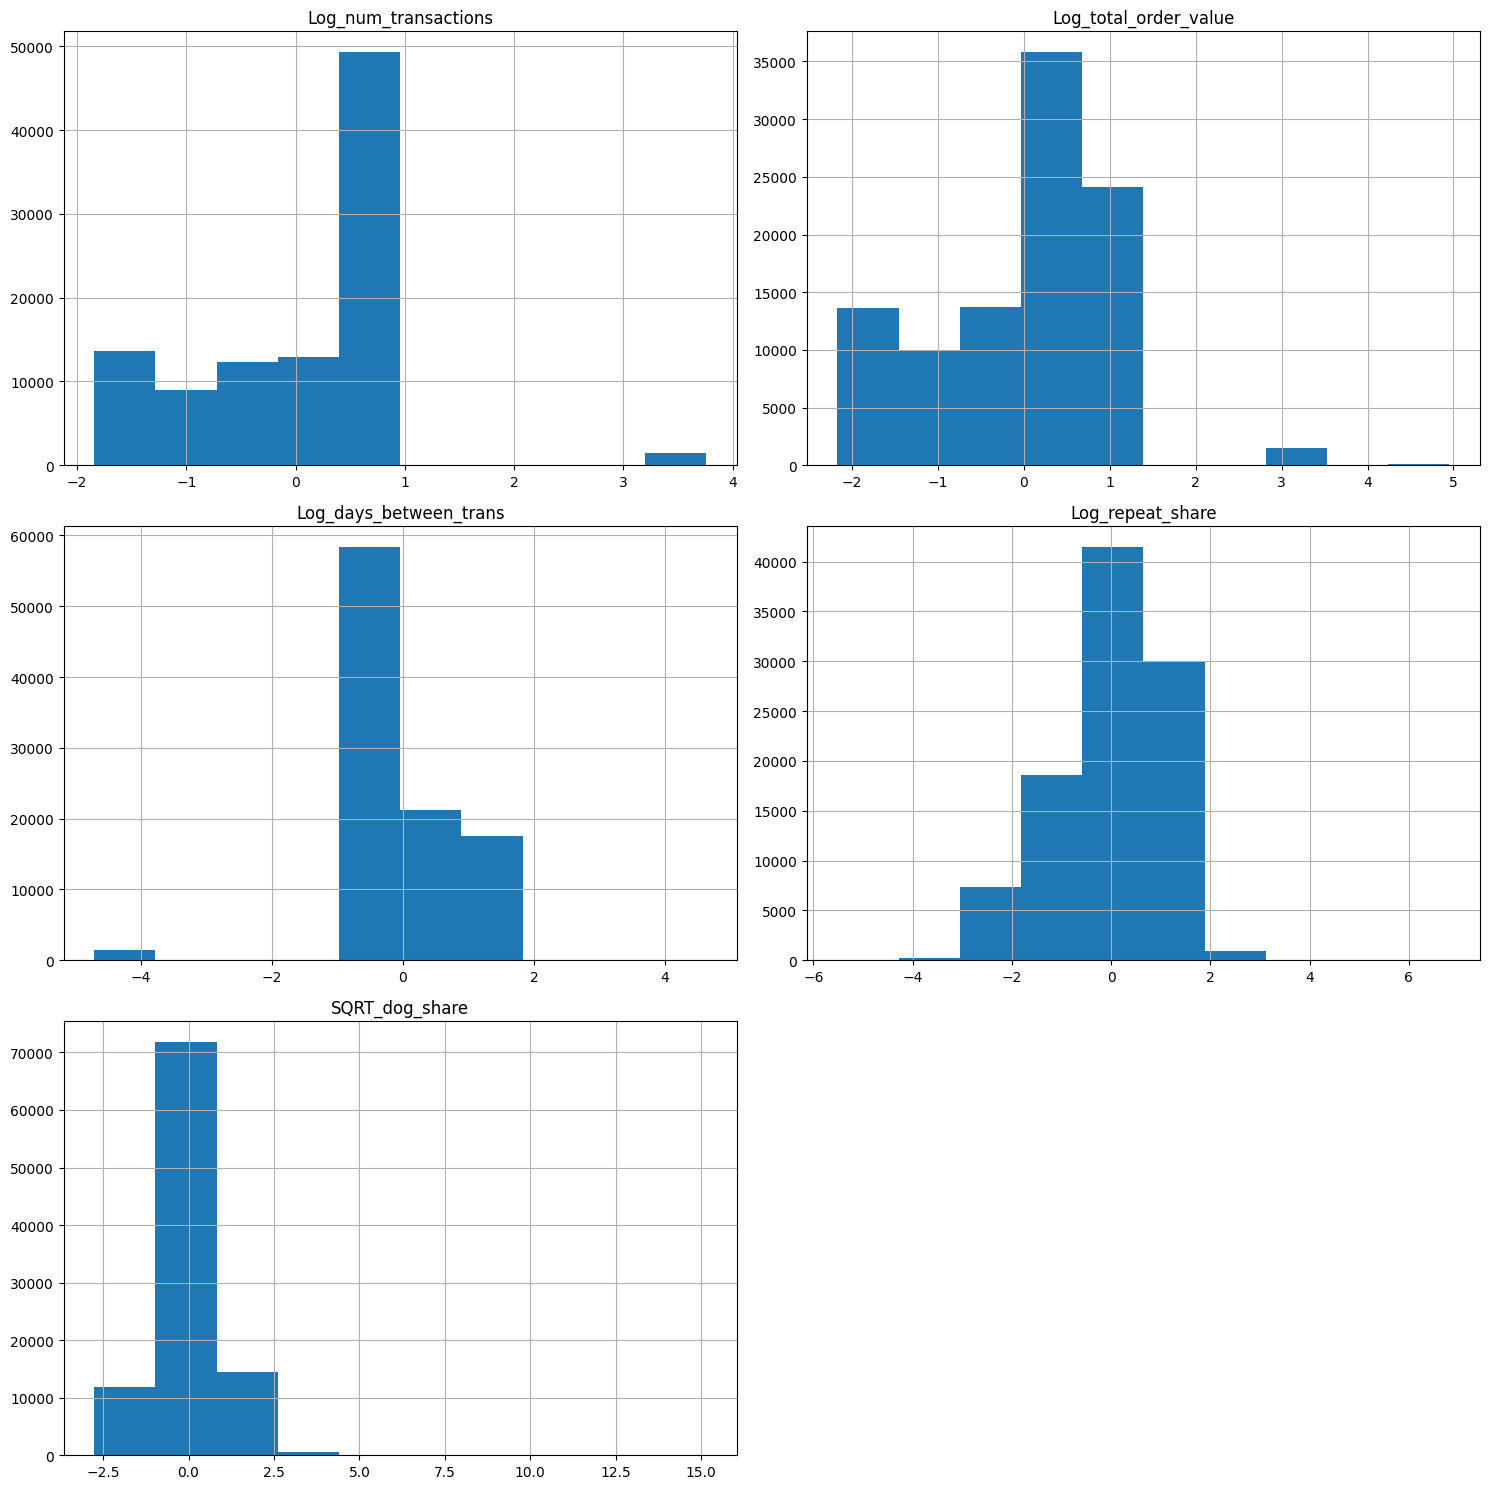

In [29]:
# Show histograms of all numeric variables in the dataset
df_prepared.hist(figsize = (15,15))
plt.tight_layout()
plt.show()

### Summarizing `Standardization` observations
- After standardization, all variables now operate on a similar scale, enhancing the uniformity and comparability across features for clustering.

## 3. Customer Segmentation using KMeans

### 3.1 Finding value of k

In [30]:
from sklearn.cluster import KMeans

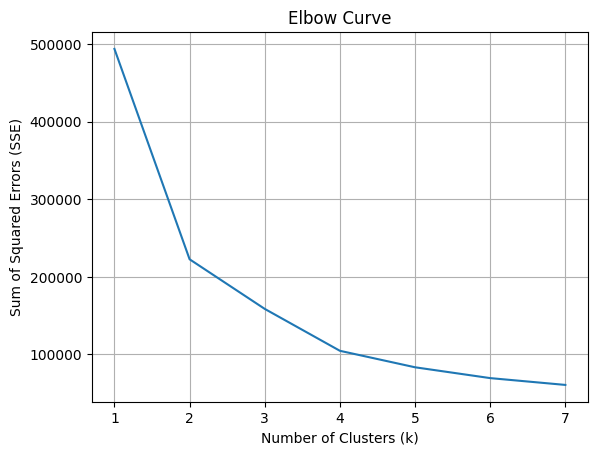

In [31]:
SSE = []
for i in range(1, 8):
    model_i = KMeans(n_clusters=i, max_iter=300, tol=0.0001, n_init=10, random_state=99)
    model_i.fit(df_prepared)
    SSE.append(model_i.inertia_)

# Plot the elbow curve
k = range(1, 8)
plt.plot(k, SSE)

# Add more information to the plot
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid(True)
plt.show()

**Observation:**
- The elbow curve suggests a notable bend around k = 3, indicating that beyond this point, the decrease in the sum of squared errors (SSE) becomes less pronounced
- Therefore, k = 3 might be a good choice for the number of clusters as it represents a balance between cluster compactness and model complexity

### 3.2 Apply k-means

In [32]:
model = KMeans(n_clusters = 3, max_iter=300, tol=0.0001, n_init=10, random_state=99)
model.fit(df_prepared)

KMeans(n_clusters=3, n_init=10, random_state=99)

In [33]:
# Print the SSE, number of interations run, and the centroids
print("Attributes of the clustering solution for k=3:")
print("SSE :", round(model.inertia_, 1))
print("Num of iterations :" , model.n_iter_)
print("\nCluster centers :" , model.cluster_centers_)

Attributes of the clustering solution for k=3:
SSE : 158684.7
Num of iterations : 9

Cluster centers : [[-0.7503503  -0.81280135  0.74451033 -0.6554707  -0.3031464 ]
 [ 0.6252452   0.65396426 -0.61329955  0.62407748 -0.15131116]
 [-1.81122952 -1.82598734  1.755849   -2.03643988  1.62369716]]


## 4. Cluster Evaluation and Interpretation

In [34]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score of the model
silhouette_score(df_prepared, model.labels_)

0.532793792739724

In [35]:
df_prepared['cluster'] = model.labels_
df_prepared

,Log_num_transactions,Log_total_order_value,Log_days_between_trans,Log_repeat_share,SQRT_dog_share,cluster
0,0.447429,0.609185,-0.581347,0.986649,0.108457,1
1,-1.844052,-1.846723,1.798375,-2.293978,1.446725,2
2,0.589581,0.593491,-0.601528,0.281383,0.043679,1
3,0.768624,0.754661,-0.692093,0.458435,0.716247,1
4,-0.359893,-0.577056,0.402544,-0.807872,-0.407287,0
...,...,...,...,...,...,...
98739,0.279300,0.035827,-0.179270,0.446718,0.905377,1
98740,-0.565667,-0.681513,0.572174,-1.095963,-0.363280,0
98741,0.821333,0.779477,-0.774014,0.610394,-0.809308,1
98742,0.073526,0.170730,0.003487,0.214221,-0.021663,1


In [36]:
# Show all possible "cluster" values, and how often each one occurs
df_prepared['cluster'].value_counts()

cluster
1    62076
0    26044
2    10624
Name: count, dtype: int64

In [37]:
model.cluster_centers_

array([[-0.7503503 , -0.81280135,  0.74451033, -0.6554707 , -0.3031464 ],
       [ 0.6252452 ,  0.65396426, -0.61329955,  0.62407748, -0.15131116],
       [-1.81122952, -1.82598734,  1.755849  , -2.03643988,  1.62369716]])

In [38]:
columns_df = df_prepared.drop(columns=['cluster'])
clust_means = pd.DataFrame(model.cluster_centers_, columns=columns_df.columns)

<Axes: >

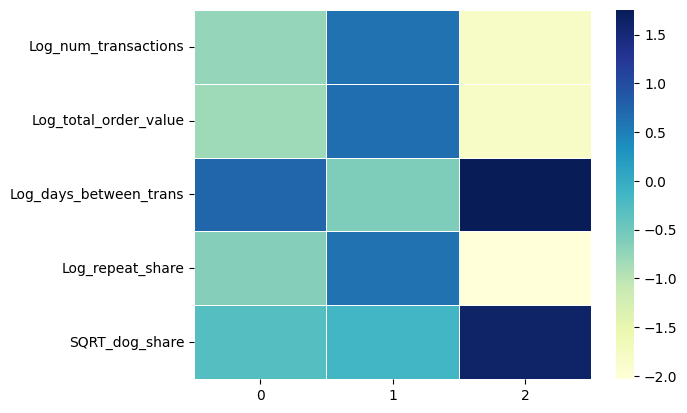

In [39]:
sns.heatmap(clust_means.T,  linewidths=.5, cmap="YlGnBu")

**Cluster interpretation**<br>

- <b>Cluster 0:</b> characterized by customers with moderately above-average transaction frequency and spending, somewhat lower purchase regularity, and a balanced mix of product interests including dog-related items.  <br />

- <b>Cluster 1:</b> characterized by customers with infrequent, low-value transactions, who buy dog products in larger intervals but show a strong preference for dog-related items when they do shop.<br />
- <b>Cluster 2:</b> characterized by lower-than-average purchase frequency and spending, longer periods between purchases, and a moderate interest in dog-related items.<br />

## 5. Output

_The final output should be in the form of a DataFrame with two columns, the CustomerId and the assigned cluster._

In [40]:
customerID = dataframe['CustomerID'].reset_index(drop=True)

In [41]:
output = pd.DataFrame(customerID)
output['cluster'] = df_prepared['cluster']

In [42]:
output

,CustomerID,cluster
0,dwa726,1
1,asy963,2
2,zgt592,1
3,spt267,1
4,oog686,0
...,...,...
98739,wgq403,1
98740,awj343,0
98741,ebz290,1
98742,rrk667,1
